# Gradient Descent for Linear Regression (Part 3)
> Under the hood of gradient descent for model optimization

- toc: true 
- badges: true
- comments: true
- author: Isaac Flath
- categories: [Gradient Descent]

# Why part 3?

I have done a couple blog posts on Gradient Descent for linear regression focusing on the basic algorithm.  In this post, I will be covering some more advanced gradient descent algorithms.  I will post as I complete a section rather than waiting until I have every variation posted.  This is partially to show some popular ones, but the more important thing to understand from this post is that all these advanced algorithms are really just minor tweaks on the basic algorithm.

# Goal Recap
The goal of linear regression is to find parameter values that fit a linear function to data points.  The goodness of fit is measured by a cost function.  The lower the cost, the better the model.  Gradient Descent is a method to minimize a cost function.  Gradient descent is a widely used tool and is used frequently in tuning predictive models.  It’s important to understand the method so you can apply it to various models and are not limited to using black box models.  This approach will use the sum of squares cost function to take a predicted line and slowly change the regression coefficients until the line is a line of best fit.

This post will cover the algorithms.  Part 4 of this series will focus on scaling this up to larger datasets.  One of the primary tools of scaling is using stochastic gradient descent, which is just a fancy way to say "just use a subset of the points instead of all of them".

# Background

Our goal is to define the equation $y=\theta_0+\theta_1x$.  This is the same thing as $y=mx+b$.  For this post I will use $y=mx+b$ language with $m$ being the slope and $b$ being the y intercept.

> Note: In order to adjust $m$, I will take $m$ - <$m$ PathValue> * <adj $\alpha$>.

> Note: In order to adjust $b$, I will take $b$ - <$b$ PathValue> * <adj $\alpha$>.

Each of these advanced algorithms either change the Path Value, or change $\alpha$.  I will show what the calculation for each is for each algorthm is, have a written explanation, and python code that illustrates it.

# Setup

Here is where I load libraries, define my dataset, and create a graphing function.

In [4]:
#collapse-hide
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

xs = np.random.randint(-100,100,100)
ys = xs * np.random.randint(-10,100) + np.random.randint(-2000,2000,100)
alpha = 0.0001
cycles = 1000

def graph_gradient_descent(values,cycles):
    plt.scatter(values['x'],values['y'])
    plt.scatter(values['x'],values['cycle0'])
    plt.scatter(values['x'],values['cycle'+str(cycles)])

    labels = ['y','initial','final']
    plt.legend(labels)
    plt.ylim(-5000,5000)
    plt.xlim(-100,100)
    plt.show()

# Basic Gradient Descent

This is the basic gradient descent algorithm that all others are based on.  If you are not clear on how gradient descent works, please refer to the background section for a review or Gradient Descent Part 1 Blog Post for more details.  I will use this same format below for each algorithm, and change only what is necessary for easier comparison.

### Inputs
$\alpha = 0.01$

n = number of data points

### New Formulas
$\alpha_{adj} = \frac{1}{n}\alpha$

$PathValue_m$ = $PathValue_bx$
    
$PathValue_b = y_{pred}-y_{obs}$

Each variation after this does 1 of 3 things to modify this algorithm:
+ Adjusts $\alpha$ by some amount
+ Adjust $PathValue$ by some amount.
+ Adjust both $\alpha$ and $PathValue$.

Really logically speaking, what else can you do?  These are the only values that are used to adjust our values, so any tweaks must involve those.  We can modify number through addition, subtraction, multiplication, and division:  If you get stuck, try to get back to those basics.

### Python Function

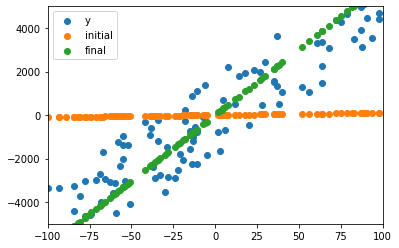

In [5]:
def gradient_descent(xs,ys,alpha,cycles):
    n = len(xs)
    adj_alpha = (1/n)*alpha
    
    values = pd.DataFrame({'x':xs,'y':ys})
    weights = pd.DataFrame({'cycle0':[1,1,0,0]},index=['m','b','pvb','pvm'])
    values['cycle0'] = weights['cycle0'].m*values['x'] + weights['cycle0'].b
    
    for cycle in range(1,cycles+1):
        p_cycle_name = 'cycle'+str(cycle-1)
        c_cycle_name = 'cycle'+str(cycle)
        

        path_value_b = sum(values[p_cycle_name]-values['y'])
        path_value_m = sum(path_value_b * values['x'])
        
        new_m = weights[p_cycle_name].m - path_value_m * adj_alpha
        new_b = weights[p_cycle_name].b - path_value_b * adj_alpha
        
        weights[c_cycle_name] = [new_m,
                                new_b,
                                path_value_m,
                                path_value_b]
        
        y_pred = weights[c_cycle_name].m*values['x'] + weights[c_cycle_name].b
        
        values[c_cycle_name] = y_pred
        
    return weights,values
        


weights, values = gradient_descent(xs,ys,alpha,cycles)

graph_gradient_descent(values,cycles)

# Momentum

### Concept

The idea of momentum is to use the previous path values to influence the new path value.  It's taking a weighted average of the previous path value and the new calculation.  This is referred to as momentum because it is using the momentum from previous points to change the size of the step to take.  To control what kind of weighted average is used, we define $\beta$.

This is useful and effective because we want to have very large steps early on, but the closer we get to the optimal values the lower we want our learning rate to be.  This allows us to do that, and if we overshoot then it will average with previous path values and lower the step size.  This allows for larger steps while minimizing the risk of our gradient descent going out of control.

### What is different

What is different:  $PathValue$ has changed and is using a new input $\beta$

If you look at $PathValue_b$ you will notice a change in this formula.  $PathValue_m$ multiplies $PathValue_b$ by our x value for that point, so it is effected as well.

### New Inputs

$\beta = 0.9$

### New Formulas
$\alpha_{adj} = \frac{1}{n}\alpha$

$PathValue_m$ = $PathValue_bx$
    
$PathValue_b = (\beta)(PathValue_{b_{previous}}) + (1 - \beta)(y_{pred}-y_{obs})$

### Python Function

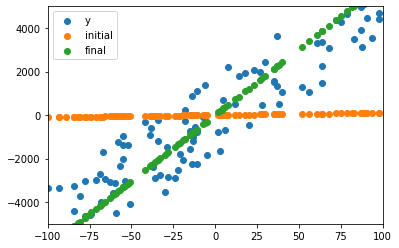

In [13]:
beta = 0.9
def gradient_descent_momentum(xs,ys,alpha,cycles,beta):
    n = len(xs)
    adj_alpha = (1/n)*alpha
    
    values = pd.DataFrame({'x':xs,'y':ys})
    weights = pd.DataFrame({'cycle0':[1,1,0,0]},index=['m','b','pvm','pvb'])
    values['cycle0'] = weights['cycle0'].m*values['x'] + weights['cycle0'].b
    
    for cycle in range(1,cycles+1):
        p_cycle_name = 'cycle'+str(cycle-1)
        c_cycle_name = 'cycle'+str(cycle)
        
        path_value_b = sum(values[p_cycle_name]-values['y'])
        path_value_m = sum(path_value_b * values['x'])
        
        if cycle > 1:
            path_value_b = (beta) * weights[p_cycle_name].pvb + (1-beta) * path_value_b
            path_value_m = (beta) * weights[p_cycle_name].pvm + (1-beta) * path_value_m
        
        new_m = weights[p_cycle_name].m - path_value_m * adj_alpha
        new_b = weights[p_cycle_name].b - path_value_b * adj_alpha
        
        weights[c_cycle_name] = [new_m,
                                new_b,
                                path_value_m,
                                path_value_b]
        
        y_pred = weights[c_cycle_name].m*values['x'] + weights[c_cycle_name].b
        
        values[c_cycle_name] = y_pred
        
    return weights,values

weights, values = gradient_descent_momentum(xs,ys,alpha,cycles,beta)

graph_gradient_descent(values,cycles)